In [1]:
import os
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline

In [2]:
# plt.style.use('seaborn-v0_8-dark')
# plt.rcParams["font.family"] = 'times new roman'

# plot formatting
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# grid lines
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'both'

plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5

dcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']

pd.set_option('future.no_silent_downcasting', True)
pd.set_option('future.no_silent_downcasting', True)

# orders of magnitude
M = 1_000_000
B = 1_000_000_000
T = 1_000_000_000_000

## Get data

In [3]:
# directories
data_dir = os.path.abspath('../data')
char_dir = os.path.join(data_dir, 'chart')
summ_dir = os.path.join(data_dir, 'summary')

In [4]:
# get symbols
char_symbs = [x.split('-')[-1].split('.')[0] for x in os.listdir(char_dir)]
summ_symbs = [x.split('-')[-1].split('.')[0] for x in os.listdir(summ_dir)]

symbols = sorted(set(char_symbs) & set(summ_symbs))

In [5]:
prices = {}
returns = {}
N = len(symbols)

print('Progress (/10): |', end='')

i = 0
for n, symbol in enumerate(symbols):

    src = os.path.join(char_dir, f'chart-{symbol}.json')
    with open(src, 'r') as f:
        chart = json.load(f)

    src = os.path.join(summ_dir, f'summary-{symbol}.json')
    with open(src, 'r') as f:
        summary = json.load(f)

    timestamp = chart['timestamp']
    quote = chart['indicators']['quote'][0]
    adjclose = chart['indicators']['adjclose'][0]
    data = quote | adjclose

    df = pd.DataFrame(data, index=timestamp)
    df.index = df.index.astype('datetime64[s]').date
    df['adj'] = df['adjclose'] / df['close']

    cols = ['open', 'close', 'low', 'high', 'volume']
    df[cols] = df[cols].mul(df['adj'], axis=0)
    df['mean'] = df[['open', 'close', 'low', 'high']].mean(axis=1)

    # volume by outstanding shares
    shares_outstanding = summary['defaultKeyStatistics']['sharesOutstanding']['raw']
    df['volshare'] = df['volume'] / shares_outstanding
    prices[symbol] = df.copy()

    cols = ['open', 'close', 'low', 'high', 'mean', 'volume']
    df[cols] = df[cols].pct_change()
    
    df = df.replace({np.inf : np.nan, -np.inf : np.nan})
    df = df.dropna()

    # add returns
    returns[symbol] = df.copy()

    # progress bar
    if n % int(N/10) == 0:
        print(i, end='|')
        i+=1

Progress (/10): |0|1|2|3|4|5|6|7|8|9|10|

In [6]:
dfp = pd.concat(prices)
dfp.index.names = ['ticker', 'date']
dfp = dfp.reset_index()

dfp['date'] = dfp['date'].astype('datetime64[s]')

In [31]:
dfr = pd.concat(returns)
dfr.index.names = ['ticker', 'date']
dfr = dfr.reset_index()

dfr['date'] = dfr['date'].astype('datetime64[s]')

# calculate rank
cols = ['low', 'high', 'open', 'close', 'mean']

for col in cols:
    print(col)
    dfr = dfr.sort_values(['date', col], ascending=False)
    dfr[f'rank_{col}'] = dfr.groupby('date').cumcount()

low
high
open
close
mean


# Analysis

In [8]:
# TODO
# - look at top 5 daily return stocks
# - look at weekly returns

In [38]:
col = 'low'
cond = dfr[f'rank_{col}'] < 10
top = dfr[cond]

top = top.set_index(['date', 'ticker'])
top = top.sort_values(['date', col], ascending=False)

top.head(50)

low     close      high    volume      open  \
date       ticker                                                     
2025-04-23 aph     0.103813  0.082129  0.158381  1.506696  0.181536   
           smci    0.103483  0.075867  0.126892  0.740231  0.097739   
           vst     0.089695  0.065436  0.104486  0.441174  0.114155   
           syf     0.079558  0.027801  0.089918 -0.204534  0.062829   
           mu      0.075030  0.038741  0.071023  0.294017  0.091057   
           rcl     0.074815  0.039215  0.088776  0.464658  0.085948   
           dell    0.074339  0.060419  0.076121  0.880602  0.074548   
           pwr     0.073653  0.047584  0.078781  0.588686  0.078911   
           now     0.072511  0.059818  0.073819  0.890574  0.076350   
           ba      0.071987  0.060608  0.082715  0.776841  0.070769   
2025-04-22 efx     0.089815  0.138372  0.123696  0.351650  0.107302   
           pnr     0.085575  0.092199  0.090161  0.523889  0.071357   
           ivz     0.078240  0.082665  0.092987  0.560842  0.058824   
           fslr    0.073902  0.105349  0.118173  3.183490  0.039855   
           mrna    0.067382  0.024274  0.019732 -0.198942  0.051602   
           mchp    0.058006  0.021811  0.038452 -0.285198  0.067819   
           ulta    0.055099  0.035551  0.044535 -0.130653  0.037109   
           dhr     0.054304  0.038441  0.075415  0.376750  0.069948   
           dgx     0.051806  0.067836  0.073096  0.730088  0.032818   
           nke     0.051215  0.016750  0.030696 -0.024808  0.025711   
2025-04-21 fis     0.081127  0.024001  0.042220  0.289351  0.081766   
           dltr    0.059943  0.006444  0.011358 -0.176752  0.083050   
           stt     0.053775 -0.007753 -0.011079 -0.393397  0.060927   
           dg      0.046154  0.027291  0.028734  0.112344  0.050533   
           dfs     0.039154  0.035582  0.059002  3.199494  0.082392   
           wst     0.037814  0.019713 -0.002996 -0.466461 -0.009327   
           rmd     0.036188 -0.009582 -0.000840 -0.151316  0.012536   
           kr      0.035304  0.015305  0.011579 -0.146388  0.039623   
           elv     0.031308 -0.042023 -0.035480 -0.357203  0.081179   
           enph    0.021053 -0.017511 -0.011579 -0.115436  0.035693   
2025-04-17 lly     0.125284  0.142958  0.134470  2.284200  0.112699   
           apa     0.052561  0.048146  0.033672 -0.080873  0.047492   
           trgp    0.041682  0.010945  0.023426 -0.271299  0.045225   
           dltr    0.040447  0.081000  0.076777  0.560035  0.020813   
           fang    0.038133  0.056980  0.050083  0.791335  0.037971   
           dvn     0.037749  0.034471  0.031815 -0.014193  0.037386   
           mchp    0.034692  0.016074  0.008073 -0.466031  0.038389   
           hban    0.033588  0.030143  0.034841  0.179470  0.033133   
           pld     0.030823  0.018048  0.017368 -0.152905  0.013842   
           qcom    0.029744  0.006778  0.006118 -0.319097  0.027678   
2025-04-16 hpe     0.028169 -0.008661 -0.022523 -0.470048  0.030812   
           abt     0.027150  0.027571  0.044128  0.560664  0.016298   
           aptv    0.026789 -0.000591  0.044650  0.056778  0.034848   
           nem     0.025120  0.025101  0.034808  0.522985  0.026904   
           trgp    0.020941  0.027612  0.019623  0.954303  0.015224   
           eqt     0.018560  0.002168  0.018431  0.228192  0.018138   
           cf      0.017062  0.013403  0.021017  0.451314  0.018449   
           o       0.014963  0.004385  0.013651 -0.066759  0.010101   
           pm      0.014154  0.002436  0.006955  0.381026  0.019617   
           lmt     0.013953  0.015972  0.015736  0.249449  0.006452   

                     adjclose       adj      mean  volshare  rank_low  \
date       ticker                                                       
2025-04-23 aph      71.150002  1.000000  0.131377  0.015724         0   
           smci     32.900002  1.000000  0.101088  0.094909         1   
           vst     120.000000  1.000000

In [ ]:
pv = dfr.pivot(index='date', columns='ticker', values=cols)
data = {}
for col in cols:
    data.update({
        ('ticker', col) : pv[col].idxmax(axis=1),
        ('max', col) : pv[col].max(axis=1)
        })
    
# stocks with highest one-day return
rmax = pd.DataFrame(data)
rmax.tail(20)

In [11]:

ticks = 0.01
pct = rmax['max']
pct = (pct / ticks).round(0) * ticks
counts = pct.apply(pd.value_counts)
counts.index.name = 'Daily return %'
freq = counts / counts.sum()

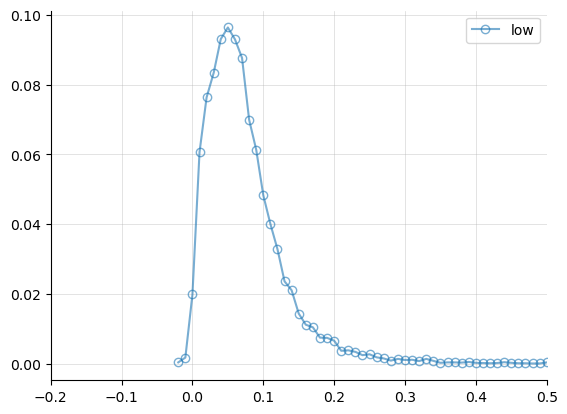

In [12]:
fig, ax = plt.subplots()

col = 'low'

ds = freq[col]
x, y = ds.index, ds.values
ax.plot(x, y, label=col, marker='o', fillstyle='none', alpha=0.6)

ax.set_xlim(-.2, .5)

ax.legend()
plt.show()

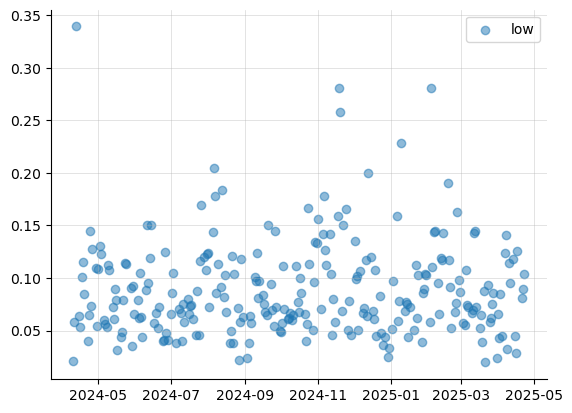

In [13]:

fig, ax = plt.subplots()

weeks = 52
ds = rmax.iloc[-(weeks*5):]

col = 'low'
x, y = ds.index, ds[('max', col)]
ax.scatter(x, y, label=col, alpha=0.5)

# ax.axhline(0, ls='--', c='gray')
ax.legend()

plt.show()

## Leads and Lags

In [14]:
col = 'low'
nshifts = 10

r = dfr[['date', 'ticker', col]]
r = r.rename(columns={col : 0})

for shift in range(-nshifts, nshifts+1):
    r[-shift] = r.groupby('ticker')[0].shift(shift)

merge = rmax['ticker'][col].reset_index()
merge.columns = ['date', 'ticker']

merge = pd.merge(merge, r, on=['date', 'ticker'], how='left')
merge = merge.set_index(['date', 'ticker'])
merge = merge[sorted(merge.columns)]
merge.columns.name = 'leads'
merge.columns = merge.columns.astype(int)

In [15]:
# TODO
# Stratify by day 0 return level

years = 3
thresholds = np.linspace(0, 0.3, 7)

days = (years*52*5)
sdf = merge.iloc[-days:]

for threshold in thresholds:

    cond = (sdf[0] threshold)
    desc = sdf[cond].describe().T

    fig, ax = plt.subplots()

    ax.set_title(f'{col} price in {threshold:.0%}'.title())

    n, N = cond.sum(), len(sdf)
    ax.set_xlabel(f'{n} of {N:,} trading days ({n/N:.2%})')

    x, y = desc.index, desc['mean']
    ci = 1.96*desc['std']

    c = 'dimgray' # dcolors[0]

    ax.plot(x, y, marker='o', fillstyle='none', c=c, label='mean')

    kwargs = dict(facecolors='None', edgecolors=c)
    ax.scatter(x, desc['max'], marker='v', label='max', **kwargs)    
    ax.scatter(x, desc['min'], marker='^', label='min', **kwargs)

    w = 0.1
    left, right = x-w, x+w

    top, bottom = y+ci, y-ci
    top = [min(x) for x in zip(top, desc['max'])]
    bottom = [max(x) for x in zip(bottom, desc['min'])]

    coords = [
        ((x, x), (top, bottom)),
        ((left, right), (top, top)),
        ((left, right), (bottom, bottom)),
    ]

    for h, v in coords:
        ax.plot(h, v, c=c, lw=0.75)

    ax.set_xticks(x[::2])
    ax.axhline(0, ls='--', c='red', lw=0.5)
    ax.yaxis.minorticks_on()

    plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3770207082.py, line 12)